In [1]:
cd ..

/home/wesg/research/ordinal-probing


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from load import load_model
import datasets
import seaborn as sns

from feature_datasets.common import *
import utils
import os

from probe_experiment import load_probe_results
from analysis.generalization import*
from analysis.probe_plots import *

%matplotlib inline

In [3]:
from make_prompt_datasets import *
import pprint
for k, v in ENTITY_PROMPTS.items():
    print(k, v.keys())

art dict_keys(['empty', 'random', 'release', 'empty_all_caps'])
headline dict_keys(['empty', 'empty_wo_period', 'when_w_period', 'when_wo_period'])
historical_figure dict_keys(['empty', 'random', 'when', 'when_all_caps'])
world_place dict_keys(['empty', 'empty_all_caps', 'random', 'coords'])
us_place dict_keys(['empty', 'random', 'coords', 'where_us'])
nyc_place dict_keys(['empty', 'random', 'where_is', 'where_nyc'])


In [4]:
experiment_name = 'full_prompts'
models = ['Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf']
trial_info = {
    'World Map': ('world_place', 'coords', 'coords'),
    'USA Map': ('us_place', 'coords', 'where_us'),
    'NYC Map': ('nyc_place', 'coords', 'where_nyc'),
    'Historical Figures': ('historical_figure', 'death_year', 'when'),
    'Entertainment': ('art', 'release_date', 'release'),
    'Headlines': ('headline', 'pub_date', 'when_w_period'),
}

In [5]:
def make_result_df_dict(models, trial_info, experiment_name):
    rdf_dict = {}
    for name, trial in trial_info.items():
        entity_type, feature_name, prompt = trial
        trial_rdfs = {}
        for model in models:
            probe_result = load_probe_results(
                experiment_name, model, entity_type, feature_name, prompt)
            rdf = pd.DataFrame(probe_result['scores']).T
            rdf.index.name = 'layer'
            trial_rdfs[model] = rdf
            
        trial_rdf = pd.concat(trial_rdfs, names=['model'])
        trial_rdf.columns = trial_rdf.columns.map('_'.join)
        trial_rdf = trial_rdf.reset_index()
        rdf_dict[name] = trial_rdf
    return rdf_dict

In [6]:
rdf_dict = make_result_df_dict(models, trial_info, experiment_name)

In [7]:
# increase text size
def main_plot_performance_by_layer(rdf_dict, metric='test_r2', metric_label='test $R^2$', fontsize=11, normalize_layer=True, save_name=''):
    plt.rcParams.update({'font.size': fontsize})
    fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
    for i, (name, trial) in enumerate(trial_info.items()):
        entity_type, feature_name, prompt = trial
        rdf = rdf_dict[name]
        ax = axs[i//3, i%3]
        for model in models:
            data_df = rdf[rdf.model == model]
            layer = data_df.layer.values
            if normalize_layer:
                layer = layer / layer.max()
            ax.plot(layer, data_df[metric].values, label=model)
        ax.set_title(name)
        if i == 0:
            ax.legend(title='Model', loc='lower right', labels=[m[:-3] for m in models])
        ax.grid(alpha=0.5, linestyle='--')
        if i % 3 == 0:
            ax.set_ylabel(metric_label)
        if i // 3 == 1:
            ax.set_xlabel('model depth')

        # turn off top and bottom splines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()

    if save_name:
        plt.savefig(os.path.join('figures', save_name))
        
    return fig, axs


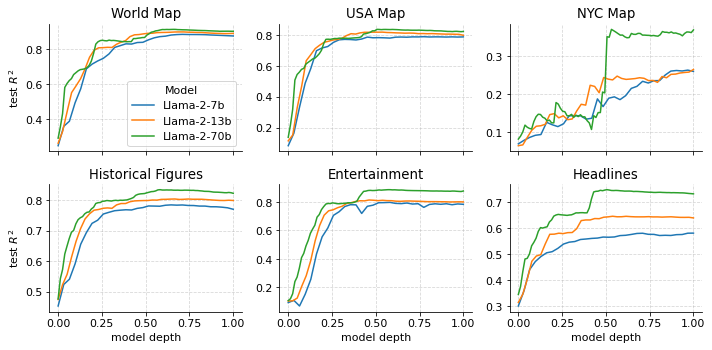

In [8]:
main_plot_performance_by_layer(rdf_dict, save_name='main_r2');

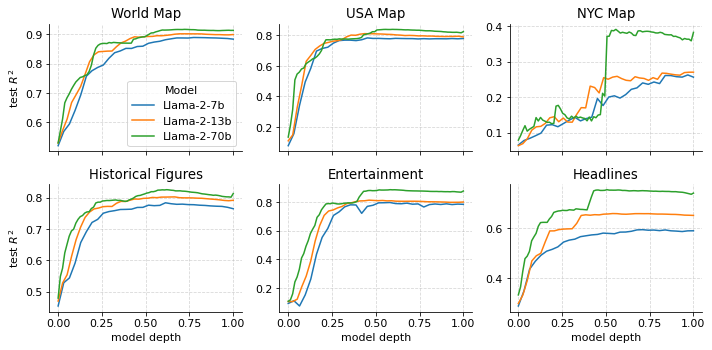

In [8]:
main_plot_performance_by_layer(rdf_dict, save_name='main_r2');

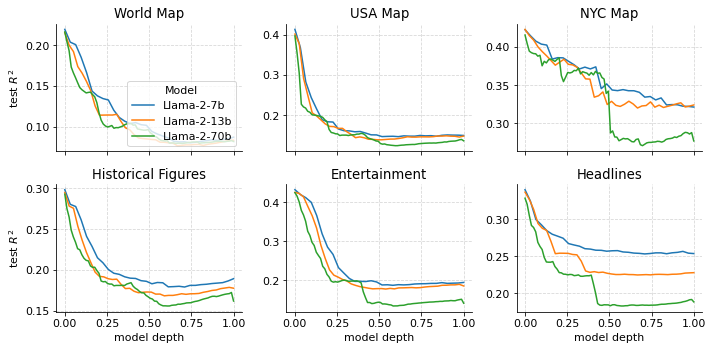

In [9]:
main_plot_performance_by_layer(rdf_dict, metric='test_prox_error');

In [8]:
def make_result_df_dict_multi_prompt(models, trial_info, experiment_name):
    rdf_dict = {}
    for name, trial in trial_info.items():
        entity_type, feature_name, prompts = trial
        trial_rdfs = {}
        for model in models:
            for prompt in prompts:
                probe_result = load_probe_results(
                    experiment_name, model, entity_type, feature_name, prompt)
                rdf = pd.DataFrame(probe_result['scores']).T
                rdf.index.name = 'layer'
                trial_rdfs[model, prompt] = rdf
        trial_rdf = pd.concat(trial_rdfs, names=['model', 'prompt'])
        trial_rdf.columns = trial_rdf.columns.map('_'.join)
        trial_rdf = trial_rdf.reset_index()
        rdf_dict[name] = trial_rdf
    return rdf_dict

In [9]:
experiment_name = 'full_prompts'
models = ['Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf']
model = models[-1]
# trial_info = {
#     'World Map': ('world_place', 'coords', ('empty', 'describe', 'where_is', 'coords', 'where_is_no_comma', 'where_is_normalized')),
#     'USA Map': ('us_place', 'coords', ('empty', 'where_us')),
#     'NYC Map': ('nyc_place', 'coords', ('where_is', 'where_nyc', 'where_nyc_normalized')),
#     'Historical Figures': ('historical_figure', 'death_year', ('empty', 'death_date', 'death_date_occupation')),
#     'Entertainment': ('art', 'release_date', ('empty', 'heard', 'release')),
#     'Headlines': ('headline', 'pub_date', ('article_wo_period', 'article_w_period')),
# }
trial_info = {
    'World Map': ('world_place', 'coords', ('empty', 'random', 'coords', 'empty_all_caps')),
    'USA Map': ('us_place', 'coords', ('empty', 'random', 'coords', 'where_us')),
    'NYC Map': ('nyc_place', 'coords', ('empty', 'random', 'where_is', 'where_nyc')),
    'Historical Figures': ('historical_figure', 'death_year', ('empty', 'random', 'when', 'when_all_caps')),
    'Entertainment': ('art', 'release_date', ('empty', 'random', 'release', 'empty_all_caps')),
    'Headlines': ('headline', 'pub_date', ('empty', 'empty_wo_period', 'when_w_period', 'when_wo_period')),
}

In [10]:
prompt_result_dict = make_result_df_dict_multi_prompt(models, trial_info, experiment_name)

In [19]:
# increase text size
def full_prompt_performance_by_layer_one_model(rdf_dict, metric='test_r2', metric_label='test $R^2$', fontsize=11, normalize_layer=True, model='Llama-2-70b-hf', save_name=''):
    plt.rcParams.update({'font.size': fontsize})
    fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
    for i, (name, trial) in enumerate(trial_info.items()):
        entity_type, feature_name, prompts = trial
        rdf = rdf_dict[name]
        ax = axs[i//3, i%3]
        for prompt in prompts:
            data_df = rdf[(rdf.prompt == prompt) & (rdf.model == model)]
            layer = data_df.layer.values
            if normalize_layer:
                layer = layer / layer.max()
            ax.plot(layer, data_df[metric].values, label=prompt)
        ax.set_title(name)
        ax.legend(title='Prompt', loc='lower right')
        ax.grid(alpha=0.5, linestyle='--')
        if i % 3 == 0:
            ax.set_ylabel(metric_label)
        if i // 3 == 1:
            if normalize_layer:
                ax.set_xlabel('model depth')
            else:
                ax.set_xlabel('layer')

        # turn off top and bottom splines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()

    if save_name:
        plt.savefig(os.path.join('figures', save_name))

    return fig, axs


# increase text size
def full_prompt_performance_by_layer_all_models(rdf_dict, models, metric='test_r2', metric_label='test $R^2$', fontsize=11, normalize_layer=True, save_name=''):
    plt.rcParams.update({'font.size': fontsize})
    fig, axs = plt.subplots(6, 3, figsize=(12, 13), sharex=True, sharey=False)
    for i, (name, trial) in enumerate(trial_info.items()):
        entity_type, feature_name, prompts = trial
        rdf = rdf_dict[name]
        for j, model in enumerate(models):
            ax = axs[i, j]
            for prompt in prompts:
                data_df = rdf[(rdf.prompt == prompt) & (rdf.model == model)]
                layer = data_df.layer.values
                if normalize_layer:
                    layer = layer / layer.max()
                ax.plot(layer, data_df[metric].values, label=prompt)
            if i == 0:
                ax.set_title(model[:-3])
            if j == 2:
                # put legend outside figure
                ax.legend(title=name + ' prompt', loc='upper left', bbox_to_anchor=(1, 1))
            ax.grid(alpha=0.5, linestyle='--')
            if j == 0:
                ax.set_ylabel(name + ' ' + metric_label)
            if i == 5:
                if normalize_layer:
                    ax.set_xlabel('model depth')
                else:
                    ax.set_xlabel('layer')

            # turn off top and bottom splines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    plt.tight_layout()

    if save_name:
        plt.savefig(os.path.join('figures', save_name))

    return fig, axs

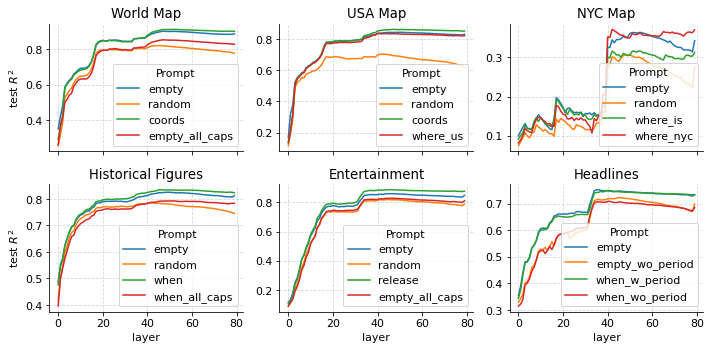

In [20]:
full_prompt_performance_by_layer_one_model(prompt_result_dict, save_name='prompt_sensitivity_70b', normalize_layer=False);

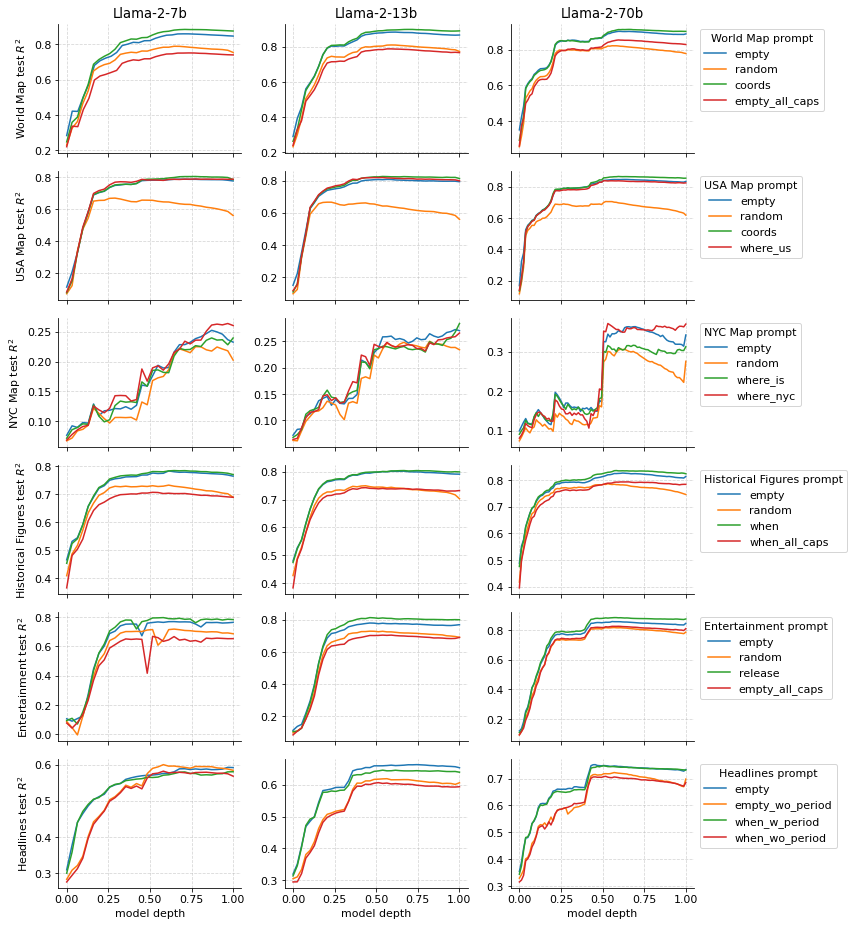

In [21]:
full_prompt_performance_by_layer_all_models(prompt_result_dict, models, save_name='prompt_sensitivity_all', normalize_layer=True);

In [28]:
prompt_result_dict['World Map'].sort_values('test_r2', ascending=False).reset_index().loc[50:100, ['prompt', 'layer', 'test_r2']]

,prompt,layer,test_r2
50,coords,69,0.913328
51,coords,74,0.913250
52,coords,71,0.912991
53,where_is,69,0.912982
54,coords,46,0.912898
55,coords,73,0.912769
56,coords,72,0.912741
57,where_is,70,0.912671
58,where_is,71,0.912624
59,where_is_normalized,52,0.912570


# Hparam results

In [13]:
def load_all_results(models, trial_info, experiment_name):
    result_dict = {}
    for name, trial in trial_info.items():
        entity_type, feature_name, prompts = trial
        for model in models:
            for prompt in prompts:
                probe_result = load_probe_results(
                    experiment_name, model, entity_type, feature_name, prompt)

                result_dict[model, prompt, entity_type, feature_name] = probe_result
    return result_dict

In [14]:
results = load_all_results(models, trial_info, experiment_name)

FileNotFoundError: [Errno 2] No such file or directory: 'results/full_prompts/Llama-2-7b-hf/world_place/coords/probes/lsq_train.none.none.last.c.p'

In [25]:
alpha_dict = {}
for k, v in results.items():
    for layer, alpha_array in v['probe_alphas'].items():
        alpha_dict[k + (layer, )] = alpha_array

alpha_df = pd.DataFrame(alpha_dict).T
alpha_df.index.names = ['model', 'prompt', 'entity_type', 'feature_name', 'layer']

alpha_df['argmin'] = alpha_df.apply(lambda x: x.argmin(), axis=1)

#pandas display 200 rows
pd.set_option('display.max_rows', 200)
alpha_df.groupby(['model', 'layer'])['argmin'].describe()#.head()

count       mean       std   min    25%   50%    75%  \
model          layer                                                         
Llama-2-13b-hf 0       24.0   0.000000  0.000000   0.0   0.00   0.0   0.00   
               1       24.0   0.666667  0.761387   0.0   0.00   0.5   1.00   
               2       24.0   2.583333  1.059806   0.0   2.00   3.0   3.00   
               3       24.0   3.333333  1.129319   0.0   3.00   4.0   4.00   
               4       24.0   3.958333  0.858673   1.0   4.00   4.0   4.00   
               5       24.0   4.666667  0.761387   2.0   5.00   5.0   5.00   
               6       24.0   4.833333  0.564660   3.0   5.00   5.0   5.00   
               7       24.0   5.500000  0.589768   4.0   5.00   6.0   6.00   
               8       24.0   5.708333  0.550033   4.0   5.75   6.0   6.00   
               9       24.0   5.833333  0.637022   4.0   6.00   6.0   6.00   
               10      24.0   5.958333  0.550033   5.0   6.00   6.0   6.00   
               11      24.0   5.916667  0.583592   5.0   6.00   6.0   6.00   
               12      24.0   6.041667  0.464306   5.0   6.00   6.0   6.00   
               13      24.0   6.333333  0.701964   5.0   6.00   6.0   7.00   
               14      24.0   6.541667  0.721060   5.0   6.00   6.5   7.00   
               15      24.0   6.625000  0.710939   5.0   6.00   7.0   7.00   
               16      24.0   6.916667  0.583592   6.0   7.00   7.0   7.00   
               17      24.0   7.166667  0.868115   6.0   7.00   7.0   8.00   
               18      24.0   7.416667  0.775532   6.0   7.00   7.0   8.00   
               19      24.0   7.750000  0.607919   7.0   7.00   8.0   8.00   
               20      24.0   8.041667  0.690253   7.0   8.00   8.0   8.00   
               21      24.0   8.333333  0.816497   7.0   8.00   8.0   9.00   
               22      24.0   8.708333  0.750604   7.0   8.00   9.0   9.00   
               23      24.0   9.000000  0.589768   8.0   9.00   9.0   9.00   
               24      24.0   9.083333  0.583592   8.0   9.00   9.0   9.00   
               25      24.0   9.333333  0.761387   8.0   9.00   9.0  10.00   
               26      24.0   9.500000  0.834058   8.0   9.00  10.0  10.00   
               27      24.0   9.666667  0.761387   8.0   9.00  10.0  10.00   
               28      24.0   9.833333  0.761387   8.0   9.00  10.0  10.00   
               29      24.0  10.083333  0.583592   9.0  10.00  10.0  10.00   
               30      24.0  10.083333  0.583592   9.0  10.00  10.0  10.00   
               31      24.0  10.208333  0.658005   9.0  10.00  10.0  11.00   
               32      24.0  10.333333  0.701964   9.0  10.00  10.0  11.00   
               33      24.0  10.375000  0.710939   9.0  10.00  10.5  11.00   
               34      24.0  10.458333  0.658005   9.0  10.00  11.0  11.00   
               35      24.0  10.583333  0.583592   9.0  10.00  11.0  11.00   
               36      24.0  10.750000  0.442326  10.0  10.75  11.0  11.00   
               37      24.0  10.791667  0.414851  10.0  11.00  11.0  11.00   
               38      24.0  10.875000  0.337832  10.0  11.00  11.0  11.00   
               39      24.0   8.166667  0.564660   7.0   8.00   8.0   8.25   
Llama-2-70b-hf 0       24.0   0.000000  0.000000   0.0   0.00   0.0   0.00   
               1       24.0   0.083333  0.282330   0.0   0.00   0.0   0.00   
               2       24.0   1.500000  0.722315   0.0   1.00   2.0   2.00   
               3       24.0   2.541667  0.883627   0.0   2.00   3.0   3.00   
               4       24.0   2.958333  0.858673   0.0   3.00   3.0   3.00   
               5       24.0   3.541667  0.779028   1.0   3.00   4.0   4.00   
               6       24.0   3.708333  0.550033   2.0   3.75   4.0   4.00   
               7       24.0   4.041667  0.550033   2.0   4.00   4.0   4.00   
               8       24.0   4.791667  0.588230   3.0   5.00   5.0   5.00   
               9       24.0   4.958333  0.55

# Multi Entity results

In [15]:
models = ['Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf']
trial_info = {
    'World Map': ('world_place', 'coords', 'coords'),
    'USA Map': ('us_place', 'coords', 'coords'),
    'NYC Map': ('nyc_place', 'coords', 'where_nyc'),
    'Historical Figures': ('historical_figure', 'death_year', 'when'),
    'Entertainment': ('art', 'release_date', 'release'),
    'Headlines': ('headline', 'pub_date', 'when_w_period'),
}
model_layers = {
    'Llama-2-7b-hf': 22,
    'Llama-2-13b-hf': 25,
    'Llama-2-70b-hf': 50,
}


model = 'Llama-2-70b-hf'
entity_dfs = {}
for entity_display_name, (entity_type, feature_name, prompt) in trial_info.items():
    rdf = results[(model, prompt, entity_type, feature_name)]['projections'][model_layers[model]]
    entity_df = load_entity_data(entity_type)
    entity_dfs[entity_display_name] = pd.concat([entity_df, rdf], axis=1)



KeyError: ('Llama-2-70b-hf', 'coords', 'world_place', 'coords')

In [21]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


In [43]:
subset_info = {
    'World Map': ('entity_type', 'Place type', {'populated_place': 'populated', 'structure': 'structure', 'natural_place': 'natural'}),
    'USA Map': ('entity_type', 'Place type', {'city': 'city', 'natural_place': 'natural place', 'zip': 'zipcode', 'county': 'county', 'college': 'college'}),
    'NYC Map': ('facility_t_name', 'Facility type', {'Recreational Facility': 'recreational', 'Education Facility': 'educational', 'Residential': 'residential',
            'Religious Institution': 'religious', 'Transportation Facility': 'transportation'}),
    'Historical Figures': ('occupation', 'Occupation', {'artist': 'artist', 'politician': 'politician', 'researcher':'researcher', 'military personnel': 'military', 'aristocrat': 'aristocrat'}),
    'Entertainment': ('entity_type', 'Media type', {'song': 'song', 'movie': 'movie', 'book': 'book'}),
    'Headlines': ('news_desk', 'News desk', {'Foreign': 'foreign', 'National': 'national', 'Washington': 'washington', 'Obits': 'obits', 'Politics': 'politics'}),
}

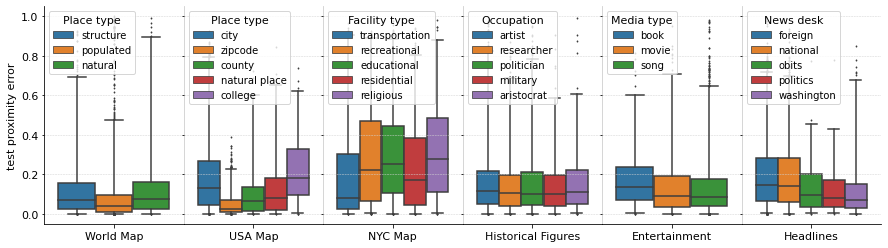

In [78]:
fig, axs = plt.subplots(1, 6, figsize=(15, 4), sharey=True)
for i, (name, subset_data) in enumerate(subset_info.items()):
    col_name, legend_title, col_mapping = subset_data
    col_list = tuple(list(col_mapping.keys()))

    ax = axs[i]
    edf = entity_dfs[name]
    test_edf = edf.loc[edf.is_test.values[:, 0]]
    test_col_edf = test_edf.loc[test_edf[col_name].isin(col_list)]

    x = [name for _ in range(len(test_col_edf))]
    y = test_col_edf['prox_error'].values
    hue = test_col_edf[col_name].apply(lambda x: col_mapping[x]).values

    sns.boxplot(x=x, y=y, hue=hue, ax=ax, whis=(1, 99), fliersize=1)
    #sns.boxenplot(x=x, y=y, hue=hue, ax=ax)
    #ax.set_yscale('log')
    #ax.set_ylim(3e-3, 1)
    ax.legend(loc='upper left', title=legend_title, frameon=True, fontsize=10, title_fontsize=11)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='y', which='both', length=2)

    if i > 0:
        ax.set_ylabel('')
        #ax.spines['left'].set_visible(False)
        ax.spines['left'].set_alpha(0.2)


axs[0].set_ylabel('test proximity error')
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('figures/entity_errors.png', bbox_inches='tight')

In [77]:
nyc_df = entity_dfs['World Map'].loc[:,~entity_dfs['World Map'].columns.duplicated()]
nyc_df.groupby(['is_test', 'entity_type']).prox_error.describe()#.sort_values('mean', ascending=False)#.head(10)

count      mean       std       min       25%  \
is_test entity_type                                                        
False   natural_place     1863.0  0.088170  0.118576  0.000000  0.013414   
        populated_place  24665.0  0.060672  0.087750  0.000000  0.009271   
        structure         5140.0  0.094650  0.110745  0.000000  0.018814   
True    natural_place      486.0  0.118847  0.152837  0.000000  0.023847   
        populated_place   6118.0  0.073719  0.106136  0.000000  0.010667   
        structure         1313.0  0.112195  0.129511  0.000025  0.026753   

                              50%       75%       max  
is_test entity_type                                    
False   natural_place    0.050954  0.124908  0.983832  
        populated_place  0.031249  0.079171  0.999823  
        structure        0.060136  0.134679  0.980321  
True    natural_place    0.073071  0.163307  0.992396  
        populated_place  0.037817  0.096950  0.999949  
        structure        0.072654  0.155261  0.927371

In [75]:
nyc_df.groupby(['is_test', 'facility_t_name']).prox_error.describe()#.sort_values('mean', ascending=False)#.head(10)

count      mean       std  \
is_test facility_t_name                                                       
False   Commercial                                837.0  0.187537  0.206864   
        Cultural Facility                         453.0  0.143647  0.168585   
        Education Facility                       3039.0  0.204418  0.194696   
        Government Facility (non public safety)   746.0  0.164325  0.185059   
        Health Services                           200.0  0.175231  0.201713   
        Miscellaneous                             629.0  0.224070  0.208303   
        Public Safety                             498.0  0.243810  0.207935   
        Recreational Facility                    3184.0  0.211903  0.204884   
        Religious Institution                    1300.0  0.251376  0.214488   
        Residential                              2423.0  0.125106  0.162936   
        Social Services                          1228.0  0.241145  0.213037   
        Transportation Facility                  1094.0  0.148484  0.193979   
        Water                                     240.0  0.135221  0.176554   
True    Commercial                                178.0  0.288279  0.280121   
        Cultural Facility                         134.0  0.191965  0.209395   
        Education Facility                        698.0  0.298842  0.233102   
        Government Facility (non public safety)   171.0  0.207217  0.237138   
        Health Services                            71.0  0.224907  0.214888   
        Miscellaneous                             145.0  0.338038  0.272485   
        Public Safety                             116.0  0.314131  0.236096   
        Recreational Facility                     851.0  0.287189  0.249123   
        Religious Institution                     308.0  0.315391  0.242406   
        Residential                               633.0  0.235550  0.217334   
        Social Services                           292.0  0.321960  0.252808   
        Transportation Facility                   326.0  0.197511  0.239299   
        Water                                      44.0  0.308137  0.295594   

                                                      min       25%       50%  \
is_test facility_t_name                                                         
False   Commercial                               0.000050  0.030699  0.111050   
        Cultural Facility                        0.000101  0.023490  0.079040   
        Education Facility                       0.000000  0.045720  0.143109   
        Government Facility (non public safety)  0.000101  0.034089  0.091592   
        Health Services                          0.000302  0.033093  0.090382   
        Miscellaneous                            0.000101  0.060238  0.153594   
        Public Safety                            0.000454  0.073357  0.187695   
        Recreational Facility                    0.000000  0.045141  0.140236   
        Religious Institution                    0.000000  0.070269  0.195710   
        Residential                              0.000000  0.014266  0.051870   
        Social Services                          0.000000  0.070383  0.175925   
        Transportation Facility                  0.000000  0.015324  0.062229   
        Water                                    0.000000  0.015513  0.053030   
True    Commercial                               0.000756  0.047144  0.185326   
        Cultural Facility                        0.000302  0.032123  0.111402   
        Education Facility                       0.000101  0.105668  0.254386   
        Government Facility (non public safety)  0.000151  0.034328  0.111050   
        Health Services                          0.000807  0.071101  0.146083   
        Miscellaneous                            0.003478  0.091844  0.275935   
        Public Safety                            0.000706  0.131150  0.263081   
        Recreational Facility                    0.0007

## Generalization

In [23]:
from generalization_experiment import *
experiment_name = 'generalization_full'
models = ['Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf']
entity_feature_mapping = {
    'world_place': 'coords',
    'us_place': 'coords',
    'nyc_place': 'coords',
    'historical_figure': 'death_year',
    'art': 'release_date',
    'headline': 'pub_date',
}
model_layers = {
    'Llama-2-7b-hf': 22,
    'Llama-2-13b-hf': 25,
    'Llama-2-70b-hf': 50,
}

all_results = {}
for model in models:
    for entity, entity_dict in TEST_SETS.items():
        feature_name = entity_feature_mapping[entity]
        for test_col in entity_dict:
            if test_col == 'creator':
                continue
            result = load_generalization_experiment(experiment_name, model, entity, feature_name, test_col)
            all_results[(model, entity, test_col)] = result


In [24]:
all_results[('Llama-2-7b-hf', 'world_place', 'entity_type')][22]['metric_df']

x_r2      y_r2        r2      x_mae  \
held_out      experiment                                                
structure     baseline        0.768640  0.773061  0.770850  18.686750   
              generalization  0.719942  0.646050  0.682996  24.019991   
natural_place baseline        0.771488  0.702222  0.736855  22.540324   
              generalization  0.792804  0.741298  0.767051  24.715685   

                                  y_mae        mae          mse       rmse  \
held_out      experiment                                                     
structure     baseline         6.072105  12.379428   615.388087  24.807017   
              generalization  10.537735  17.278863   776.411405  27.864160   
natural_place baseline         8.289073  15.414699  1072.371268  32.747080   
              generalization   8.097671  16.406678   935.629421  30.588060   

                              x_pearson    x_pearson_p  ...    y_pearson_p  \
held_out      experiment                                ...                  
structure     baseline         0.876914   0.000000e+00  ...   0.000000e+00   
              generalization   0.854085   0.000000e+00  ...   0.000000e+00   
natural_place baseline         0.880327  7.144683e-159  ...  2.350857e-130   
              generalization   0.894387   0.000000e+00  ...   0.000000e+00   

                              y_spearman   y_spearman_p  y_kendall  \
held_out      experiment                                             
structure     baseline          0.868632   0.000000e+00   0.700991   
              generalization    0.773187   0.000000e+00   0.595160   
natural_place baseline          0.853735  2.877610e-139   0.705289   
              generalization    0.853467   0.000000e+00   0.694414   

                                y_kendall_p  haversine_mse  haversine_rmse  \
held_out      experiment                                                     
structure     baseline         0.000000e+00   1.252356e+07     3538.864451   
              generalization   0.000000e+00   1.659408e+07     4073.582961   
natural_place baseline        1.877248e-119   1.556236e+07     3944.915344   
              generalization   0.000000e+00   1.661800e+07     4076.517916   

                              haversine_mae  haversine_r2  prox_error  
held_out      experiment                                               
structure     baseline          2156.456429      0.773361    0.123997  
              generalization    2989.095021      0.705345    0.175460  
natural_place baseline          2427.817903      0.832509    0.111327  
              generalization    2752.414349      0.815884    0.124662  

[4 rows x 25 columns]

In [25]:
# entity_gen_table = {
#     'World': ('world_place', 'haversine_mae', 'entity_type'),
#     'USA': ('us_place', 'haversine_mae', 'entity_type'),
#     'NYC': ('nyc_place', 'haversine_mae', 'facility_t_name'),
#     'Historical': ('historical_figure', 'mae', 'occupation'),
#     'Entertainment': ('art', 'mae', 'entity_type'),
#     'Headlines': ('headline', 'mae', 'news_desk'),
# }
entity_gen_table = {
    'World': ('world_place', 'prox_error', 'entity_type'),
    'USA': ('us_place', 'prox_error', 'entity_type'),
    'NYC': ('nyc_place', 'prox_error', 'facility_t_name'),
    'Historical': ('historical_figure', 'prox_error', 'occupation'),
    'Entertainment': ('art', 'prox_error', 'entity_type'),
    'Headlines': ('headline', 'prox_error', 'news_desk'),
}
entity_table_data = {}
for col_title, (entity, metric, test_col) in entity_gen_table.items():
    for model in models:
        rdf = all_results[(model, entity, test_col)][model_layers[model]]['metric_df']
        entity_table_data[(model, col_title)] = rdf.groupby('experiment').mean()[metric]

In [26]:
rdf

mae        mse      rmse        r2   pearson  \
held_out   experiment                                                          
National   baseline        1.143386   2.531843  1.591177  0.671455  0.824739   
           generalization  1.671649   4.744415  2.178168  0.380034  0.773900   
Washington baseline        0.903255   2.078058  1.441547 -0.528174  0.578968   
           generalization  1.079053   2.625790  1.620429 -1.230686  0.518314   
Obits      baseline        1.237469   3.311949  1.819876 -0.393241  0.491417   
           generalization  2.840345  11.485027  3.388957 -5.344384  0.264559   
Politics   baseline        1.043478   2.159259  1.469442 -0.599730  0.609797   
           generalization  1.331031   3.455592  1.858922 -1.257784  0.548866   

                               pearson_p  spearman     spearman_p   kendall  \
held_out   experiment                                                         
National   baseline         0.000000e+00  0.821465   0.000000e+00  0.635118   
           generalization   0.000000e+00  0.770644   0.000000e+00  0.582789   
Washington baseline         5.410526e-55  0.612438   4.748590e-63  0.449449   
           generalization  1.210949e-193  0.558063  1.499824e-230  0.403449   
Obits      baseline         5.131384e-09  0.457650   7.136717e-08  0.331810   
           generalization   8.689279e-13  0.233155   3.491965e-10  0.174311   
Politics   baseline         3.494244e-14  0.529149   1.892294e-10  0.377270   
           generalization   1.723267e-52  0.479699   9.084906e-39  0.341964   

                               kendall_p  prox_error  
held_out   experiment                                 
National   baseline         0.000000e+00    0.195847  
           generalization   0.000000e+00    0.270189  
Washington baseline         6.462591e-61    0.116683  
           generalization  3.063642e-226    0.132816  
Obits      baseline         3.583885e-08    0.150182  
           generalization   4.059579e-12    0.327021  
Politics   baseline         3.724463e-10    0.116248  
           generalization   6.144431e-39    0.144998

In [27]:
entity_table_df = pd.DataFrame(entity_table_data).T.rename(columns={'baseline': 'nominal', 'generalization': 'heldout'})
entity_table_df.index.names = ['model', 'dataset']
entity_table_df = entity_table_df.reset_index().pivot(columns='dataset', index='model').swaplevel(axis=1).sort_index(axis=1).round(3).loc[models].stack(level=1)


In [60]:
col_order = ['World', 'USA', 'NYC', 'Historical', 'Entertainment', 'Headlines']
entity_table_df = entity_table_df[col_order].loc[
    [(model, split) for model in models for split in ['nominal', 'heldout']]
]
entity_table_df

dataset                    World    USA    NYC  Historical  Entertainment  \
model          experiment                                                   
Llama-2-7b-hf  nominal     0.120  0.206  0.313       0.164          0.224   
               heldout     0.151  0.262  0.367       0.168          0.305   
Llama-2-13b-hf nominal     0.117  0.197  0.310       0.153          0.207   
               heldout     0.147  0.259  0.377       0.159          0.283   
Llama-2-70b-hf nominal     0.113  0.173  0.266       0.149          0.159   
               heldout     0.147  0.203  0.322       0.149          0.271   

dataset                    Headlines  
model          experiment             
Llama-2-7b-hf  nominal         0.199  
               heldout         0.289  
Llama-2-13b-hf nominal         0.171  
               heldout         0.266  
Llama-2-70b-hf nominal         0.144  
               heldout         0.219

In [28]:
col_order = ['World', 'USA', 'NYC', 'Historical', 'Entertainment', 'Headlines']
entity_table_df = entity_table_df[col_order].loc[
    [(model, split) for model in models for split in ['nominal', 'heldout']]
]
entity_table_df

dataset                    World    USA    NYC  Historical  Entertainment  \
model          experiment                                                   
Llama-2-7b-hf  nominal     0.118  0.146  0.316       0.174          0.224   
               heldout     0.150  0.234  0.373       0.179          0.305   
Llama-2-13b-hf nominal     0.109  0.158  0.314       0.165          0.207   
               heldout     0.144  0.218  0.378       0.168          0.283   
Llama-2-70b-hf nominal     0.104  0.129  0.273       0.149          0.159   
               heldout     0.147  0.185  0.326       0.153          0.271   

dataset                    Headlines  
model          experiment             
Llama-2-7b-hf  nominal         0.200  
               heldout         0.289  
Llama-2-13b-hf nominal         0.174  
               heldout         0.275  
Llama-2-70b-hf nominal         0.145  
               heldout         0.219

In [61]:
print(entity_table_df.to_latex(float_format="{:0.3f}".format))

\begin{tabular}{llrrrrrr}
\toprule
 & dataset & World & USA & NYC & Historical & Entertainment & Headlines \\
model & experiment &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Llama-2-7b-hf} & nominal & 0.120 & 0.206 & 0.313 & 0.164 & 0.224 & 0.199 \\
 & heldout & 0.151 & 0.262 & 0.367 & 0.168 & 0.305 & 0.289 \\
\cline{1-8}
\multirow[t]{2}{*}{Llama-2-13b-hf} & nominal & 0.117 & 0.197 & 0.310 & 0.153 & 0.207 & 0.171 \\
 & heldout & 0.147 & 0.259 & 0.377 & 0.159 & 0.283 & 0.266 \\
\cline{1-8}
\multirow[t]{2}{*}{Llama-2-70b-hf} & nominal & 0.113 & 0.173 & 0.266 & 0.149 & 0.159 & 0.144 \\
 & heldout & 0.147 & 0.203 & 0.322 & 0.149 & 0.271 & 0.219 \\
\cline{1-8}
\bottomrule
\end{tabular}



## Generalization of block holdout

In [29]:
structured_gen_table = {
    'World': ('world_place', 'prox_error', 'country'),
    'USA': ('us_place', 'prox_error', 'state_id'),
    'NYC': ('nyc_place', 'prox_error', 'borough_name'),
    'Historical': ('historical_figure', 'prox_error', 'death_century'),
    'Entertainment': ('art', 'prox_error', 'decade'),
    'Headlines': ('headline', 'prox_error', 'year'),
}
structured_holdout_table_data = {}
for col_title, (entity, metric, test_col) in structured_gen_table.items():
    for model in models:
        rdf = all_results[(model, entity, test_col)][model_layers[model]]['metric_df']
        structured_holdout_table_data[(model, col_title)] = rdf.groupby('experiment').mean()[metric]

In [58]:
holdout_table_df = pd.DataFrame(structured_holdout_table_data).T.rename(columns={'baseline': 'nominal', 'generalization': 'heldout'})
holdout_table_df.index.names = ['model', 'dataset']
holdout_table_df = holdout_table_df.reset_index().pivot(columns='dataset', index='model').swaplevel(axis=1).sort_index(axis=1).round(3).loc[models].stack(level=1)

col_order = ['World', 'USA', 'NYC', 'Historical', 'Entertainment', 'Headlines']
holdout_table_df = holdout_table_df[col_order].loc[
    [(model, split) for model in models for split in ['nominal', 'heldout']]
]
holdout_table_df

dataset                    World    USA    NYC  Historical  Entertainment  \
model          experiment                                                   
Llama-2-7b-hf  nominal     0.071  0.144  0.331       0.129          0.147   
               heldout     0.170  0.192  0.473       0.133          0.158   
Llama-2-13b-hf nominal     0.068  0.144  0.319       0.121          0.141   
               heldout     0.156  0.189  0.470       0.126          0.152   
Llama-2-70b-hf nominal     0.071  0.121  0.262       0.115          0.105   
               heldout     0.164  0.188  0.433       0.119          0.122   

dataset                    Headlines  
model          experiment             
Llama-2-7b-hf  nominal         0.258  
               heldout         0.264  
Llama-2-13b-hf nominal         0.223  
               heldout         0.235  
Llama-2-70b-hf nominal         0.182  
               heldout         0.200

In [30]:
holdout_table_df = pd.DataFrame(structured_holdout_table_data).T.rename(columns={'baseline': 'nominal', 'generalization': 'heldout'})
holdout_table_df.index.names = ['model', 'dataset']
holdout_table_df = holdout_table_df.reset_index().pivot(columns='dataset', index='model').swaplevel(axis=1).sort_index(axis=1).round(3).loc[models].stack(level=1)

col_order = ['World', 'USA', 'NYC', 'Historical', 'Entertainment', 'Headlines']
holdout_table_df = holdout_table_df[col_order].loc[
    [(model, split) for model in models for split in ['nominal', 'heldout']]
]
holdout_table_df

dataset                    World    USA    NYC  Historical  Entertainment  \
model          experiment                                                   
Llama-2-7b-hf  nominal     0.077  0.129  0.333       0.136          0.147   
               heldout     0.184  0.184  0.478       0.141          0.158   
Llama-2-13b-hf nominal     0.071  0.128  0.325       0.128          0.141   
               heldout     0.171  0.185  0.473       0.133          0.152   
Llama-2-70b-hf nominal     0.073  0.113  0.273       0.117          0.105   
               heldout     0.178  0.194  0.441       0.122          0.122   

dataset                    Headlines  
model          experiment             
Llama-2-7b-hf  nominal         0.262  
               heldout         0.267  
Llama-2-13b-hf nominal         0.231  
               heldout         0.242  
Llama-2-70b-hf nominal         0.183  
               heldout         0.202

In [59]:
print(holdout_table_df.to_latex(float_format="{:0.3f}".format))

\begin{tabular}{llrrrrrr}
\toprule
 & dataset & World & USA & NYC & Historical & Entertainment & Headlines \\
model & experiment &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Llama-2-7b-hf} & nominal & 0.071 & 0.144 & 0.331 & 0.129 & 0.147 & 0.258 \\
 & heldout & 0.170 & 0.192 & 0.473 & 0.133 & 0.158 & 0.264 \\
\cline{1-8}
\multirow[t]{2}{*}{Llama-2-13b-hf} & nominal & 0.068 & 0.144 & 0.319 & 0.121 & 0.141 & 0.223 \\
 & heldout & 0.156 & 0.189 & 0.470 & 0.126 & 0.152 & 0.235 \\
\cline{1-8}
\multirow[t]{2}{*}{Llama-2-70b-hf} & nominal & 0.071 & 0.121 & 0.262 & 0.115 & 0.105 & 0.182 \\
 & heldout & 0.164 & 0.188 & 0.433 & 0.119 & 0.122 & 0.200 \\
\cline{1-8}
\bottomrule
\end{tabular}



In [14]:
col_order = ['World', 'USA', 'NYC', 'Historical', 'Entertainment', 'Headlines']
holdout_table_df[col_order].loc[
    [(model, split) for model in models for split in ['nominal', 'heldout']]
]

dataset                    World    USA    NYC  Historical  Entertainment  \
model          experiment                                                   
Llama-2-7b-hf  nominal     0.071  0.144  0.331       0.129          0.147   
               heldout     0.170  0.192  0.473       0.133          0.158   
Llama-2-13b-hf nominal     0.068  0.144  0.319       0.121          0.141   
               heldout     0.156  0.189  0.470       0.126          0.152   
Llama-2-70b-hf nominal     0.071  0.121  0.262       0.115          0.105   
               heldout     0.164  0.188  0.433       0.119          0.122   

dataset                    Headlines  
model          experiment             
Llama-2-7b-hf  nominal         0.258  
               heldout         0.264  
Llama-2-13b-hf nominal         0.223  
               heldout         0.235  
Llama-2-70b-hf nominal         0.182  
               heldout         0.200

In [33]:
generalization_world_plot_data = {
    'United_States': (), 
    'United_Kingdom': (), 
    'India': (), 
    'Australia': (), 
    'Italy': (), 
    'Canada': (), 
    'South_Africa': (), 
    'Syria': (), 
    'Japan': (), 
    'Poland': (), 
    'China': (), 
    'Philippines': (), 
    'Brazil': (), 
    'Mexico': (), 
    'Sweden': (), 
    'Indonesia': (), 
    'Switzerland': (), 
    'Pakistan': (), 
    'Argentina': (), 
    'Netherlands': ()
}

In [16]:
len(generalization_world_plot_data)

20

In [31]:
world_df = load_entity_data('world_place')




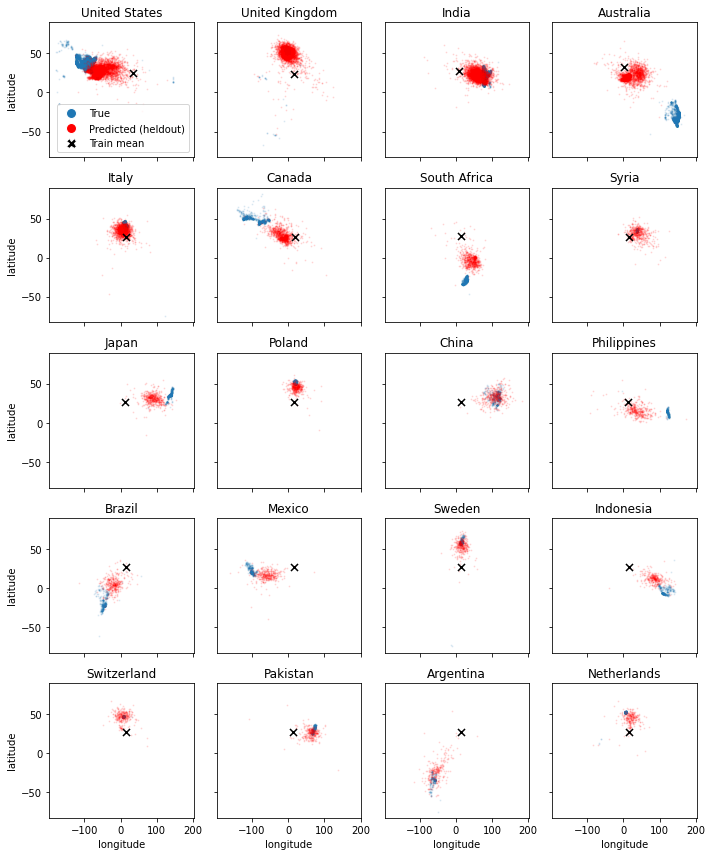

In [50]:
generalization_result_dict = all_results[('Llama-2-70b-hf', 'world_place', 'country')][50]['full']

n_rows = 5
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 12), sharex=True, sharey=True)
for ix, country in enumerate(generalization_world_plot_data.keys()):
    test_df = generalization_result_dict[country]['projection_df']
    test_ixs = test_df.is_test.values
    ax = axs[ix // n_cols, ix % n_cols]
    ax.scatter(world_df.longitude.values[test_ixs], world_df.latitude.values[test_ixs], alpha=0.1, s=1)
    ax.scatter(test_df.x.values[test_ixs], test_df.y.values[test_ixs], alpha=0.1, s=1, color='red')

    train_df = world_df.loc[world_df.country.values != country]
    train_x_mean = train_df.longitude.values.mean()
    train_y_mean = train_df.latitude.values.mean()
    ax.scatter(train_x_mean, train_y_mean, color='black', marker='x', s=50)

    ax.set_title(country.replace('_', ' '))

    if ix // n_cols == 4:
        ax.set_xlabel('longitude')
    if ix % n_cols == 0:
        ax.set_ylabel('latitude')


true_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=10, label='True')
predicted_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Predicted (heldout)')
mean_legend = plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10, label='Train mean')
axs[0, 0].legend(handles=[true_legend, predicted_legend, mean_legend], loc='lower right')

plt.tight_layout()

#plt.savefig('figures/world_place_generalization.png', bbox_inches='tight')

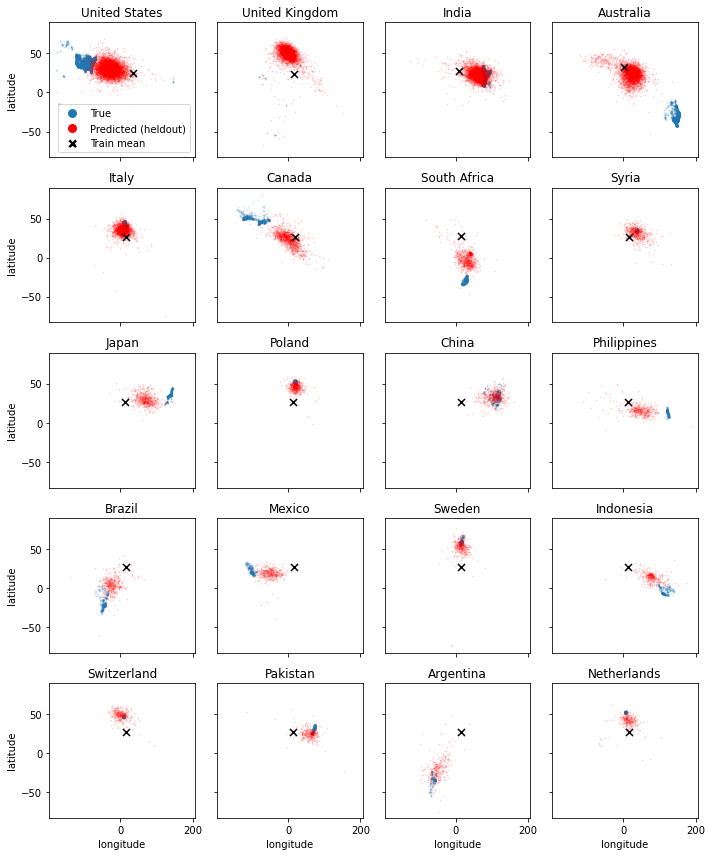

In [34]:
generalization_result_dict = all_results[('Llama-2-70b-hf', 'world_place', 'country')][50]['full']

n_rows = 5
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 12), sharex=True, sharey=True)
for ix, country in enumerate(generalization_world_plot_data.keys()):
    test_df = generalization_result_dict[country]['projection_df']
    test_ixs = test_df.is_test.values
    ax = axs[ix // n_cols, ix % n_cols]
    ax.scatter(world_df.longitude.values[test_ixs], world_df.latitude.values[test_ixs], alpha=0.1, s=1)
    ax.scatter(test_df.x.values[test_ixs], test_df.y.values[test_ixs], alpha=0.1, s=1, color='red')

    train_df = world_df.loc[world_df.country.values != country]
    train_x_mean = train_df.longitude.values.mean()
    train_y_mean = train_df.latitude.values.mean()
    ax.scatter(train_x_mean, train_y_mean, color='black', marker='x', s=50)

    ax.set_title(country.replace('_', ' '))

    if ix // n_cols == 4:
        ax.set_xlabel('longitude')
    if ix % n_cols == 0:
        ax.set_ylabel('latitude')


true_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=10, label='True')
predicted_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Predicted (heldout)')
mean_legend = plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10, label='Train mean')
axs[0, 0].legend(handles=[true_legend, predicted_legend, mean_legend], loc='lower right')

plt.tight_layout()

In [35]:
us_df = load_entity_data('us_place')
heldout = ['CA', 'TX', 'PA', 'NY', 'FL', 'OH', 'IL', 'NJ', 'NC', 'MI', 'GA', 'VA', 'WA', 'WI', 'MN', 'MO', 'MA', 'IN', 'MD', 'LA', 'AL', 'TN', 'AZ', 'OK', 'CO', 'SC', 'KY', 'OR', 'CT', 'IA', 'KS', 'AR', 'MS', 'NM', 'UT', 'WV', 'ID', 'NE', 'NV', 'SD', 'MT', 'NH', 'ME', 'ND', 'WY', 'RI', 'DE', 'VT']

x_mean = us_df.longitude.values.mean()
y_mean = us_df.latitude.values.mean()

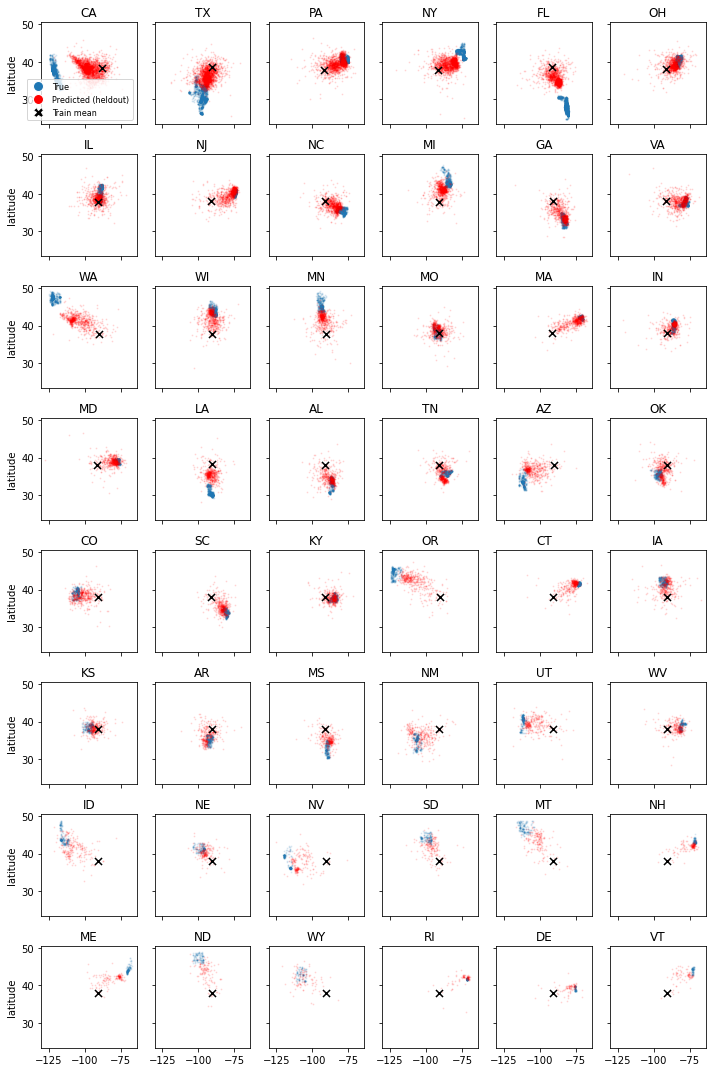

In [49]:
generalization_result_dict = all_results[('Llama-2-70b-hf', 'us_place', 'state_id')][50]['full']

n_rows = 8
n_cols = 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 15), sharex=True, sharey=True)
for ix, state in enumerate(heldout):
    test_df = generalization_result_dict[state]['projection_df']
    test_ixs = test_df.is_test.values
    ax = axs[ix // n_cols, ix % n_cols]
    ax.scatter(us_df.longitude.values[test_ixs], us_df.latitude.values[test_ixs], alpha=0.1, s=1)
    ax.scatter(test_df.x.values[test_ixs], test_df.y.values[test_ixs], alpha=0.1, s=1, color='red')

    train_df = us_df.loc[us_df.state_id.values != state]
    train_x_mean = train_df.longitude.values.mean()
    train_y_mean = train_df.latitude.values.mean()
    ax.scatter(train_x_mean, train_y_mean, color='black', marker='x', s=50)

    ax.set_title(state.replace('_', ' '))

    if ix // n_cols == n_rows:
        ax.set_xlabel('longitude')
    if ix % n_cols == 0:
        ax.set_ylabel('latitude')

true_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=10, label='True')
predicted_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Predicted (heldout)')
mean_legend = plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10, label='Train mean')
axs[0, 0].legend(handles=[true_legend, predicted_legend, mean_legend], loc='lower right', fontsize=8)

plt.tight_layout()

plt.savefig('figures/us_place_generalization.png', bbox_inches='tight')

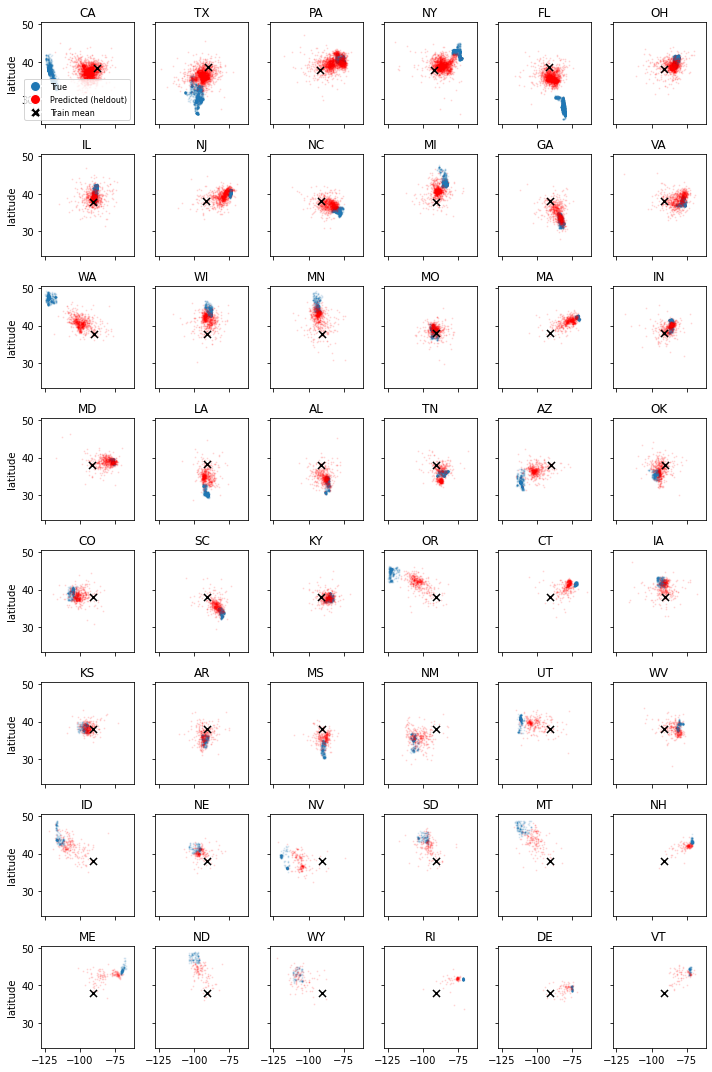

In [36]:
generalization_result_dict = all_results[('Llama-2-70b-hf', 'us_place', 'state_id')][50]['full']

n_rows = 8
n_cols = 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 15), sharex=True, sharey=True)
for ix, state in enumerate(heldout):
    test_df = generalization_result_dict[state]['projection_df']
    test_ixs = test_df.is_test.values
    ax = axs[ix // n_cols, ix % n_cols]
    ax.scatter(us_df.longitude.values[test_ixs], us_df.latitude.values[test_ixs], alpha=0.1, s=1)
    ax.scatter(test_df.x.values[test_ixs], test_df.y.values[test_ixs], alpha=0.1, s=1, color='red')

    train_df = us_df.loc[us_df.state_id.values != state]
    train_x_mean = train_df.longitude.values.mean()
    train_y_mean = train_df.latitude.values.mean()
    ax.scatter(train_x_mean, train_y_mean, color='black', marker='x', s=50)

    ax.set_title(state.replace('_', ' '))

    if ix // n_cols == n_rows:
        ax.set_xlabel('longitude')
    if ix % n_cols == 0:
        ax.set_ylabel('latitude')

true_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=10, label='True')
predicted_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Predicted (heldout)')
mean_legend = plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10, label='Train mean')
axs[0, 0].legend(handles=[true_legend, predicted_legend, mean_legend], loc='lower right', fontsize=8)

plt.tight_layout()

#plt.savefig('figures/us_place_generalization.png', bbox_inches='tight')

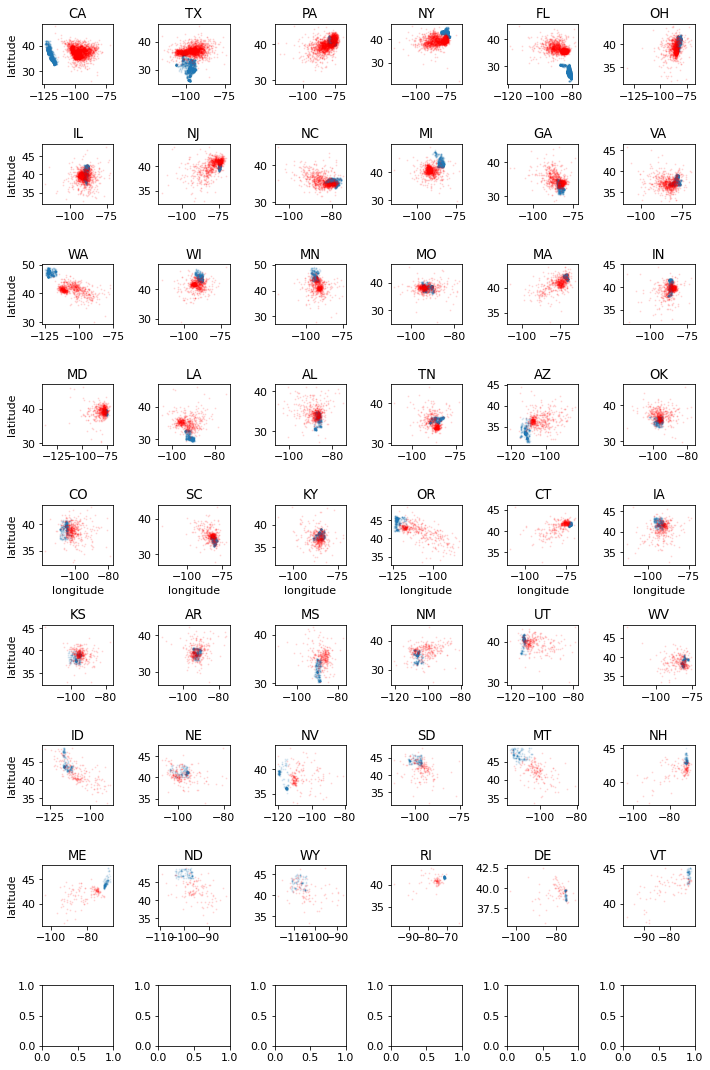

In [38]:
generalization_result_dict = all_results[('Llama-2-13b-hf', 'us_place', 'state_id')][25]['full']

n_rows = 9
n_cols = 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 15))
for ix, state in enumerate(heldout):
    test_df = generalization_result_dict[state]['projection_df']
    test_ixs = test_df.is_test.values
    ax = axs[ix // n_cols, ix % n_cols]
    ax.scatter(us_df.longitude.values[test_ixs], us_df.latitude.values[test_ixs], alpha=0.1, s=1)
    ax.scatter(test_df.x.values[test_ixs], test_df.y.values[test_ixs], alpha=0.1, s=1, color='red')

    ax.set_title(state.replace('_', ' '))

    if ix // n_cols == 4:
        ax.set_xlabel('longitude')
    if ix % n_cols == 0:
        ax.set_ylabel('latitude')

plt.tight_layout()


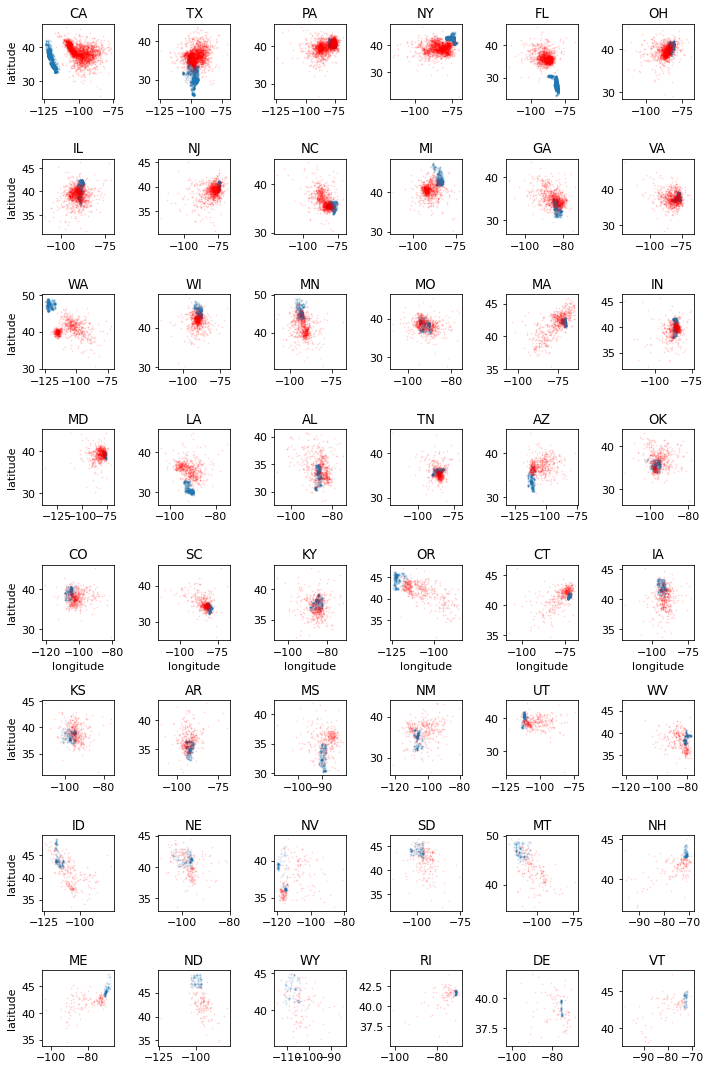

In [39]:
generalization_result_dict = all_results[('Llama-2-7b-hf', 'us_place', 'state_id')][22]['full']

n_rows = 8
n_cols = 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 15))
for ix, state in enumerate(heldout):
    test_df = generalization_result_dict[state]['projection_df']
    test_ixs = test_df.is_test.values
    ax = axs[ix // n_cols, ix % n_cols]
    ax.scatter(us_df.longitude.values[test_ixs], us_df.latitude.values[test_ixs], alpha=0.1, s=1)
    ax.scatter(test_df.x.values[test_ixs], test_df.y.values[test_ixs], alpha=0.1, s=1, color='red')

    ax.set_title(state.replace('_', ' '))

    if ix // n_cols == 4:
        ax.set_xlabel('longitude')
    if ix % n_cols == 0:
        ax.set_ylabel('latitude')

plt.tight_layout()


In [17]:
place_display_cols = ['x_mae', 'y_mae', 'mae', 'x_spearman', 'y_spearman', 'haversine_mae']
time_display_cols = ['mae', 'spearman']
for k, v in all_results.items():
    if k[1] != 'nyc_place':
        continue
    print(k)
    display_cols = place_display_cols if 'place' in k[1] else time_display_cols
    display(v[model_layers[k[0]]]['metric_df'][display_cols])
    #display(v[model_layers[k[0]]]['metric_df'][display_cols].groupby('experiment').mean())

('Llama-2-7b-hf', 'nyc_place', 'facility_t_name')


x_mae     y_mae  \
held_out                                experiment                           
Recreational Facility                   baseline        0.056595  0.065252   
                                        generalization  0.060903  0.066694   
Education Facility                      baseline        0.057478  0.062773   
                                        generalization  0.058576  0.064277   
Residential                             baseline        0.034873  0.055510   
                                        generalization  0.045455  0.061332   
Religious Institution                   baseline        0.054911  0.063185   
                                        generalization  0.067342  0.065006   
Social Services                         baseline        0.055228  0.064794   
                                        generalization  0.056964  0.064840   
Transportation Facility                 baseline        0.065112  0.057134   
                                        generalization  0.066569  0.060305   
Commercial                              baseline        0.050534  0.043248   
                                        generalization  0.052391  0.045988   
Government Facility (non public safety) baseline        0.046003  0.041548   
                                        generalization  0.051625  0.051340   
Miscellaneous                           baseline        0.048784  0.051277   
                                        generalization  0.056603  0.054887   
Public Safety                           baseline        0.062830  0.063137   
                                        generalization  0.065710  0.064081   
Cultural Facility                       baseline        0.041142  0.035798   
                                        generalization  0.044134  0.040226   
Water                                   baseline        0.090509  0.065411   
                                        generalization  0.103023  0.071464   
Health Services                         baseline        0.034857  0.054580   
                                        generalization  0.051432  0.055863   

                                                             mae  x_spearman  \
held_out                                experiment                             
Recreational Facility                   baseline        0.060924    0.334886   
                                        generalization  0.063798    0.308049   
Education Facility                      baseline        0.060125    0.325327   
                                        generalization  0.061426    0.266332   
Residential                             baseline        0.045192    0.564407   
                                        generalization  0.053393    0.393470   
Religious Institution                   baseline        0.059048    0.388387   
                                        generalization  0.066174    0.346831   
Social Services                         baseline        0.060011    0.343667   
                                        generalization  0.060902    0.320242   
Transportation Facility                 baseline        0.061123    0.712258   
                                        generalization  0.063437    0.442835   
Commercial                              baseline        0.046891    0.471560   
                                        generalization  0.049190    0.422549   
Government Facility (non public safety) baseline        0.043776    0.520268   
                                        generalization  0.051482    0.395076   
Miscellaneous                           baseline        0.050031    0.336006   
                                        generalization  0.055745    0.282166   
Public Safety                           baseline        0.062983    0.362688   
                                        generalization  0.064896    0.143312   
Cultural Facility                       baseline        0.038470    0.526667   
                                  

('Llama-2-7b-hf', 'nyc_place', 'borough_name')


x_mae     y_mae       mae  x_spearman  \
held_out      experiment                                                 
Manhattan     baseline        0.027976  0.037329  0.032653    0.344863   
              generalization  0.045281  0.049056  0.047169    0.222457   
Brooklyn      baseline        0.034371  0.059505  0.046938    0.271974   
              generalization  0.044009  0.088905  0.066457    0.141968   
Queens        baseline        0.082430  0.038878  0.060654    0.175995   
              generalization  0.122151  0.042125  0.082138    0.055451   
Bronx         baseline        0.044001  0.094349  0.069175    0.206302   
              generalization  0.064179  0.132750  0.098465    0.010038   
Staten Island baseline        0.170154  0.103457  0.136805   -0.071555   
              generalization  0.222363  0.134520  0.178442   -0.256977   

                              y_spearman  haversine_mae  
held_out      experiment                                 
Manhattan     baseline          0.189236       3.552278  
              generalization    0.175625       5.602164  
Brooklyn      baseline          0.273853       4.468814  
              generalization    0.168722       5.930086  
Queens        baseline          0.239459       9.347133  
              generalization    0.199043      13.706623  
Bronx         baseline          0.218024       5.983964  
              generalization    0.040774       8.573453  
Staten Island baseline          0.058243      19.218890  
              generalization    0.051522      25.099760

('Llama-2-13b-hf', 'nyc_place', 'facility_t_name')


x_mae     y_mae  \
held_out                                experiment                           
Recreational Facility                   baseline        0.054886  0.066132   
                                        generalization  0.061053  0.066299   
Education Facility                      baseline        0.056833  0.060125   
                                        generalization  0.058199  0.062830   
Residential                             baseline        0.034081  0.057076   
                                        generalization  0.048203  0.064549   
Religious Institution                   baseline        0.053318  0.061399   
                                        generalization  0.061088  0.066371   
Social Services                         baseline        0.054782  0.065035   
                                        generalization  0.056373  0.065142   
Transportation Facility                 baseline        0.065920  0.053785   
                                        generalization  0.066767  0.058594   
Commercial                              baseline        0.050539  0.042835   
                                        generalization  0.050029  0.044843   
Government Facility (non public safety) baseline        0.045077  0.043863   
                                        generalization  0.056598  0.045995   
Miscellaneous                           baseline        0.048554  0.051271   
                                        generalization  0.056378  0.057231   
Public Safety                           baseline        0.063367  0.062438   
                                        generalization  0.066886  0.065029   
Cultural Facility                       baseline        0.037062  0.036387   
                                        generalization  0.044314  0.041358   
Water                                   baseline        0.095833  0.068361   
                                        generalization  0.106314  0.071890   
Health Services                         baseline        0.040070  0.060459   
                                        generalization  0.054470  0.055912   

                                                             mae  x_spearman  \
held_out                                experiment                             
Recreational Facility                   baseline        0.060509    0.391076   
                                        generalization  0.063676    0.325790   
Education Facility                      baseline        0.058479    0.324737   
                                        generalization  0.060514    0.300915   
Residential                             baseline        0.045578    0.589851   
                                        generalization  0.056376    0.386723   
Religious Institution                   baseline        0.057359    0.416898   
                                        generalization  0.063729    0.345944   
Social Services                         baseline        0.059908    0.333975   
                                        generalization  0.060758    0.338443   
Transportation Facility                 baseline        0.059853    0.707757   
                                        generalization  0.062681    0.479410   
Commercial                              baseline        0.046687    0.510857   
                                        generalization  0.047436    0.476238   
Government Facility (non public safety) baseline        0.044470    0.482775   
                                        generalization  0.051297    0.353389   
Miscellaneous                           baseline        0.049912    0.388742   
                                        generalization  0.056805    0.310641   
Public Safety                           baseline        0.062902    0.304525   
                                        generalization  0.065958    0.204883   
Cultural Facility                       baseline        0.036725    0.574723   
                                  

('Llama-2-13b-hf', 'nyc_place', 'borough_name')


x_mae     y_mae       mae  x_spearman  \
held_out      experiment                                                 
Manhattan     baseline        0.026763  0.035824  0.031294    0.363435   
              generalization  0.045018  0.047761  0.046389    0.274949   
Brooklyn      baseline        0.032529  0.059887  0.046208    0.299360   
              generalization  0.043845  0.088957  0.066401    0.150549   
Queens        baseline        0.083077  0.037804  0.060440    0.196727   
              generalization  0.122378  0.041700  0.082039    0.055971   
Bronx         baseline        0.044113  0.095899  0.070006    0.166501   
              generalization  0.059609  0.131997  0.095803    0.057245   
Staten Island baseline        0.170575  0.104072  0.137323    0.013335   
              generalization  0.225975  0.134038  0.180007   -0.216590   

                              y_spearman  haversine_mae  
held_out      experiment                                 
Manhattan     baseline          0.233072       3.396691  
              generalization    0.197924       5.558378  
Brooklyn      baseline          0.352633       4.325050  
              generalization    0.186426       5.931247  
Queens        baseline          0.307655       9.409677  
              generalization    0.207614      13.734623  
Bronx         baseline          0.235044       6.004737  
              generalization    0.032021       8.135394  
Staten Island baseline          0.186651      19.266656  
              generalization    0.122226      25.491170

('Llama-2-70b-hf', 'nyc_place', 'facility_t_name')


x_mae     y_mae  \
held_out                                experiment                           
Recreational Facility                   baseline        0.048957  0.054852   
                                        generalization  0.058627  0.057441   
Education Facility                      baseline        0.051683  0.052933   
                                        generalization  0.052979  0.056458   
Residential                             baseline        0.027455  0.043393   
                                        generalization  0.036294  0.050782   
Religious Institution                   baseline        0.051738  0.059927   
                                        generalization  0.057780  0.064962   
Social Services                         baseline        0.051328  0.061095   
                                        generalization  0.052692  0.060293   
Transportation Facility                 baseline        0.053390  0.046491   
                                        generalization  0.060823  0.055085   
Commercial                              baseline        0.049703  0.042736   
                                        generalization  0.051393  0.043692   
Government Facility (non public safety) baseline        0.041772  0.035771   
                                        generalization  0.053599  0.046058   
Miscellaneous                           baseline        0.046926  0.050297   
                                        generalization  0.053172  0.051887   
Public Safety                           baseline        0.059416  0.057418   
                                        generalization  0.067250  0.061565   
Cultural Facility                       baseline        0.033211  0.032753   
                                        generalization  0.044390  0.035953   
Water                                   baseline        0.084464  0.063433   
                                        generalization  0.094397  0.061472   
Health Services                         baseline        0.034349  0.041852   
                                        generalization  0.046840  0.044930   

                                                             mae  x_spearman  \
held_out                                experiment                             
Recreational Facility                   baseline        0.051905    0.554988   
                                        generalization  0.058034    0.445760   
Education Facility                      baseline        0.052308    0.515621   
                                        generalization  0.054719    0.441548   
Residential                             baseline        0.035424    0.672447   
                                        generalization  0.043538    0.623534   
Religious Institution                   baseline        0.055832    0.479658   
                                        generalization  0.061371    0.412065   
Social Services                         baseline        0.056212    0.434157   
                                        generalization  0.056493    0.433731   
Transportation Facility                 baseline        0.049940    0.810284   
                                        generalization  0.057954    0.554357   
Commercial                              baseline        0.046220    0.495064   
                                        generalization  0.047542    0.514805   
Government Facility (non public safety) baseline        0.038771    0.586728   
                                        generalization  0.049829    0.299388   
Miscellaneous                           baseline        0.048611    0.413718   
                                        generalization  0.052529    0.411626   
Public Safety                           baseline        0.058417    0.448237   
                                        generalization  0.064408    0.238688   
Cultural Facility                       baseline        0.032982    0.644165   
                                  

('Llama-2-70b-hf', 'nyc_place', 'borough_name')


x_mae     y_mae       mae  x_spearman  \
held_out      experiment                                                 
Manhattan     baseline        0.027605  0.033683  0.030644    0.397944   
              generalization  0.042179  0.046483  0.044331    0.269799   
Brooklyn      baseline        0.032983  0.050228  0.041605    0.389719   
              generalization  0.045531  0.084775  0.065153    0.209747   
Queens        baseline        0.069087  0.036091  0.052589    0.285218   
              generalization  0.121513  0.042782  0.082148    0.052885   
Bronx         baseline        0.038111  0.079861  0.058986    0.289644   
              generalization  0.057262  0.122690  0.089976    0.141580   
Staten Island baseline        0.139869  0.083466  0.111668   -0.002906   
              generalization  0.222350  0.128317  0.175334   -0.222101   

                              y_spearman  haversine_mae  
held_out      experiment                                 
Manhattan     baseline          0.336377       3.427010  
              generalization    0.307942       5.217135  
Brooklyn      baseline          0.286606       4.206127  
              generalization    0.155261       6.032125  
Queens        baseline          0.403278       7.886786  
              generalization    0.226978      13.649135  
Bronx         baseline          0.226729       5.197019  
              generalization   -0.010562       7.748620  
Staten Island baseline          0.006507      15.801317  
              generalization    0.172533      25.067208

# Main time plot

In [15]:
model_name = 'Llama-2-70b-hf'

layer = 48

art_df = load_entity_data('art')
headline_df = load_entity_data('headline')
figure_df = load_entity_data('historical_figure')

art_probe_result = load_probe_results(experiment_name, model_name, 'art', 'release_date', 'release')
headline_probe_result = load_probe_results(experiment_name, model_name, 'headline', 'pub_date', 'when_w_period')
figure_probe_result = load_probe_results(experiment_name, model_name, 'historical_figure', 'death_year', 'when')

art_probe = (art_probe_result['probe_directions'][layer], art_probe_result['probe_biases'][layer])
headline_probe = (headline_probe_result['probe_directions'][layer], headline_probe_result['probe_biases'][layer])
figure_probe = (figure_probe_result['probe_directions'][layer], figure_probe_result['probe_biases'][layer])

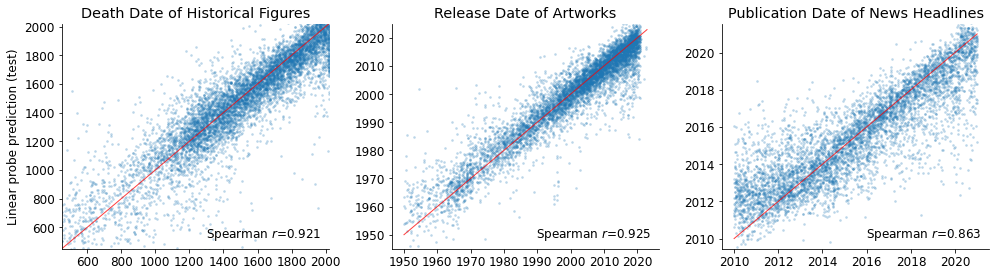

In [22]:
from scipy.stats import spearmanr
from datetime import datetime


fig, axs = plt.subplots(1, 3, figsize=(14, 4))

NS_PER_YEAR = 1e9 * 60 * 60 * 24 * 365.25

# fontsize to 12
plt.rcParams.update({'font.size': 12})

# Figure
figure_pred_datetime = figure_probe_result['projections'][layer].projection
figure_true_datetime = figure_df.death_year.values
figure_is_test = figure_df.is_test.values

figure_spearman = spearmanr(figure_true_datetime[figure_is_test], figure_pred_datetime[figure_is_test]).correlation

ax = axs[0]
ax.scatter(figure_true_datetime[figure_is_test], figure_pred_datetime[figure_is_test], s=3, alpha=0.2)
ax.plot(
    [figure_true_datetime.min(), figure_true_datetime.max()], 
    [figure_true_datetime.min(), figure_true_datetime.max()], 
    color='red', lw=1, alpha=0.75
)

ax.set_ylim(450, 2020)
ax.set_xlim(450, 2020)
ax.set_title('Death Date of Historical Figures')
ax.set_ylabel('Linear probe prediction (test)')
ax.annotate(f'Spearman $r$={figure_spearman:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom')

y_ticks = ax.get_yticks()
ax.set_xticks(y_ticks[1:-1])


# Art
art_pred_datetime = pd.to_datetime(art_probe_result['projections'][layer].projection * NS_PER_YEAR)
art_true_datetime = pd.to_datetime(art_df.release_date.values)
art_is_test = art_df.is_test.values

art_spearman = spearmanr(art_true_datetime[art_is_test], art_pred_datetime[art_is_test]).correlation

ax = axs[1]
ax.scatter(art_true_datetime[art_is_test], art_pred_datetime[art_is_test], s=3, alpha=0.2)
ax.plot(
    [art_true_datetime.min(), art_true_datetime.max()], 
    [art_true_datetime.min(), art_true_datetime.max()], 
    color='red', lw=1, alpha=0.75
)
ax.set_title('Release Date of Artworks')
ax.set_ylim(datetime(1945, 1, 1), datetime(2025, 1, 1))
ax.annotate(f'Spearman $r$={art_spearman:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom')

# Headline
headline_pred_datetime = pd.to_datetime(headline_probe_result['projections'][layer].projection * NS_PER_YEAR)
headline_true_datetime = pd.to_datetime(headline_df.pub_date.values)
headline_is_test = headline_df.is_test.values

headline_spearman = spearmanr(headline_true_datetime[headline_is_test], headline_pred_datetime[headline_is_test]).correlation

ax = axs[2]
ax.scatter(headline_true_datetime[headline_is_test], headline_pred_datetime[headline_is_test], s=3, alpha=0.2)
ax.plot(
    [headline_true_datetime.min(), headline_true_datetime.max()], 
    [headline_true_datetime.min(), headline_true_datetime.max()], 
    color='red', lw=1, alpha=0.75
)
ax.set_title('Publication Date of News Headlines')
ax.annotate(f'Spearman $r$={headline_spearman:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/time_scatter_main.png', bbox_inches='tight')
